In [50]:
import os

import torch
import json
import torch.nn as nn
from torch.utils.data import DataLoader
from collections import defaultdict
from matplotlib import pyplot
import numpy as np
import pandas as pd

from gcd_data_manipulation import ClusterDataset
from gcd_data_manipulation import prepare_data
from shared_workspace_module import SharedWorkspaceModule

import matplotlib.pyplot as plt

In [51]:
job_id = 6318371744
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def rmse(yhat, y):
    print(type(yhat), type(y))
    return np.sqrt(np.mean((y - yhat)**2))


def rmspe(yhat, y):
    # EPSILON = 1e-10
    # print(((y - yhat) / (y + EPSILON))**2)
    return rmse(yhat, y) / np.mean(y)

def rmsse_2(yhat, y):
    e = y - yhat
    m = 1 / (len(y) - 1)
    t = np.sum(abs(np.delete((y - np.roll(y, 1)), 0)))

    print((m * t)**2)

    # return np.sqrt((e / (m * t))**2)
    return np.sqrt(np.mean((e / (m * t))**2))

def rmsse_multitarget(yhat, y):
    e = y - yhat
    t0 = np.mean(abs((y - np.roll(y, 1))[1:]))
    t1 = np.mean(abs((y - np.roll(y, 2))[2:]))
    t2 = np.mean(abs((y - np.roll(y, 3))[3:]))
    return np.sqrt(np.mean((e / np.mean(t0 + t1 + t2))**2))

def lag_rmse(y):
    yhat = np.delete(np.roll(y, 1), 0)
    y = np.delete(y, 0)
    # print(y)
    # print(yhat)
    return rmse(yhat, y)

def rmsse(yhat, y):
    e_2 = (y - yhat)**2
    m = 1 / (len(y) - 1)
    t = np.sum(abs(np.delete((y - np.roll(y, 1)), 0)))
    return np.sqrt(np.mean(e_2 / (m * t)))

def t_rmse(yhat, y):
    # yhat = outputs.numpy()
    # y = targets.numpy()
    return torch.sqrt(torch.mean(torch.square(y - yhat)))

def t_rmspe(yhat, y):
    return t_rmse(yhat, y) / torch.mean(y)

In [52]:
def test_model(exp):
    #print(os.getcwd())
    #pass
    checkpoint = torch.load(f'../models/gwt_models/gwt_model_{exp}.pth')

    args = checkpoint['model_args']
    print(f'last epoch: {checkpoint["epoch"]}')
    print(f'last loss: {checkpoint["loss"]}')

    with open('columns_selection.json') as f:
        columns_selection = json.load(f)

    columns_to_consider = columns_selection[args.columns_to_consider]
    num_targets = len(args.prediction_targets)

    preprocessed_data = prepare_data(f'../data/task-usage_job-ID-{job_id}_total.csv', columns_to_consider, targets=args.prediction_targets, sliding_window=args.sliding_window, aggr_type='mean')

    test_data = ClusterDataset(preprocessed_data, num_targets=num_targets, training=True, split_percentage=1)
    test_data.values.to(device)

    model = SharedWorkspaceModule(
        h_dim=args.h_dim,
        ffn_dim=args.ffn_dim,
        num_layers=args.num_layers,
        num_heads=args.num_heads,
        dropout=args.dropout,
        shared_memory_attention=args.shared_memory_attention,
        share_vanilla_parameters=args.share_vanilla_parameters,
        use_topk=args.use_topk,
        topk=args.topk,
        mem_slots=args.mem_slots,
        num_targets=num_targets
    ).cuda()

    model.load_state_dict(checkpoint['state_dict'])

    model.eval()

    test_loader = DataLoader(test_data, batch_size=args.batch_size)
    criterion = nn.L1Loss().cuda()
    result = defaultdict(list)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            if num_targets == 1:
                targets = targets.reshape((targets.shape[0], 1))

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            #print(outputs, targets)
            print(f'WOW {t_rmspe(torch.roll(targets[:,-1], 1)[1:], targets[1:,-1])}')
            print(f'WOW2 {torch.roll(outputs[:,-1], 1)[1:], targets[1:,-1]}')


            test_loss = loss.item() #/ targets.shape[0]

            result['loss'].append(test_loss)

            for pred in outputs:
                result['predicted_value'].append(pred.to('cpu').numpy())

            for act in targets:
                result['actual_value'].append(act.to('cpu').numpy())

    return result

In [53]:
def eval_result(result):
    print(f'Loss: {result["loss"]}')
    # print(type(result["predicted_value"]), np.array(result["predicted_value"]))
    print(f'RMSE: {rmse(np.array(result["predicted_value"]), np.array(result["actual_value"]))}')
    print(f'RMSPE: {rmspe(np.array(result["predicted_value"]), np.array(result["actual_value"]))}')
    # print(np.array(result["actual_value"]))
    #print(f'RMSSE: {rmsse(np.array(result["predicted_value"]), np.array(result["actual_value"]))}')
    #print(f'RMSSE 2: {rmsse_2(np.array(result["predicted_value"]), np.array(result["actual_value"]))}')
    print(f'LAG: {lag_rmse(np.array(result["actual_value"])) / np.mean(result["actual_value"])}')
    print(f'RMSSE MULTI: {rmsse_multitarget(np.array(result["predicted_value"]), np.array(result["actual_value"]))}')





In [54]:
fig_path = '../experiments_result/figures_GWT'

def plot_res(result, save=None):
    for i in range(0, len(result['predicted_value'][0])):
        plt.figure(figsize=(18,12))
        plt.plot([x[i] for x in result['predicted_value']], color='b')
        plt.plot([x[i] for x in result['actual_value']], color='y')
        plt.xlabel('Time Step', fontsize=40)
        plt.ylabel('Efficiency', fontsize=40)
        plt.legend(['Prediction', 'Actual'], fontsize=30)
        if save is not None:
            out_path = os.path.join(fig_path, f'pred_act_{save}_{i}.png')
            plt.savefig(out_path)
        plt.show()


In [59]:
res = test_model('tr_sw_lb3_p012')
eval_result(res)

last epoch: 200
last loss: 0.0005726686979443589
transformer embed_dim 32
functional? False
total heads 4
head dim 8
use topk?True
topk:3
MEM SLOTS:4
Null attention:False
USING SHARED MEMORY ATTENTION +++++++++
Using gate style unit
query:4224
key:4224
value:1056
attention_mlp:1056
layernorm1:64
layernorm2:64
input_projector:1056
input projector:32
input_gate_projector:11744
memory_gate_projector:8448
relational volatie!!!
WOW 0.7740050554275513
WOW2 (tensor([0.2599, 0.2599, 0.2599, 0.0053, 0.0048, 0.0048, 0.0048, 0.0540, 0.6643,
        0.0053, 0.1927, 0.0047, 0.0742, 0.9684, 0.9674, 0.9693, 0.9693, 0.9684,
        0.9664, 0.0047, 0.0050, 0.0050, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048,
        0.0235, 0.2093, 0.9769, 0.9750, 0.9769, 0.9769, 0.9769, 0.9769, 0.9769,
        0.0047, 0.0051, 0.0063, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048,
        0.0048, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048,
        0.0048, 0.0048], device='cuda:0'), tensor([9.8716e-04, 2

d:\uni\bachelorarbeit\repo\polaris-ai\venv\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [56]:
#res['predicted_value']

In [57]:
#res['actual_value']

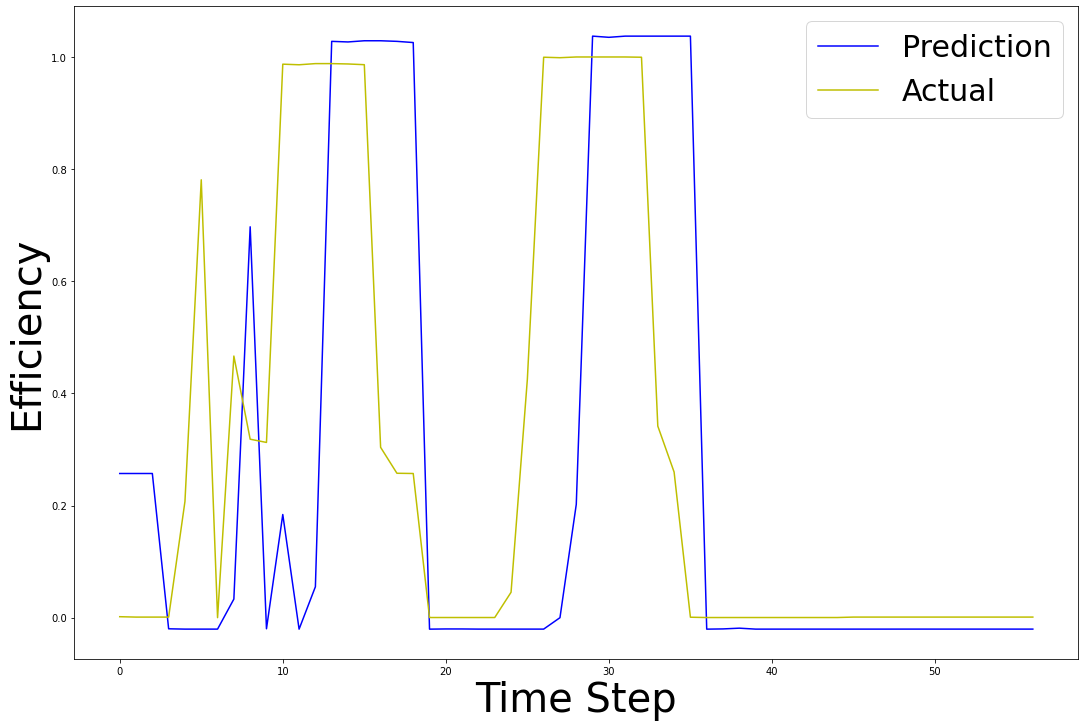

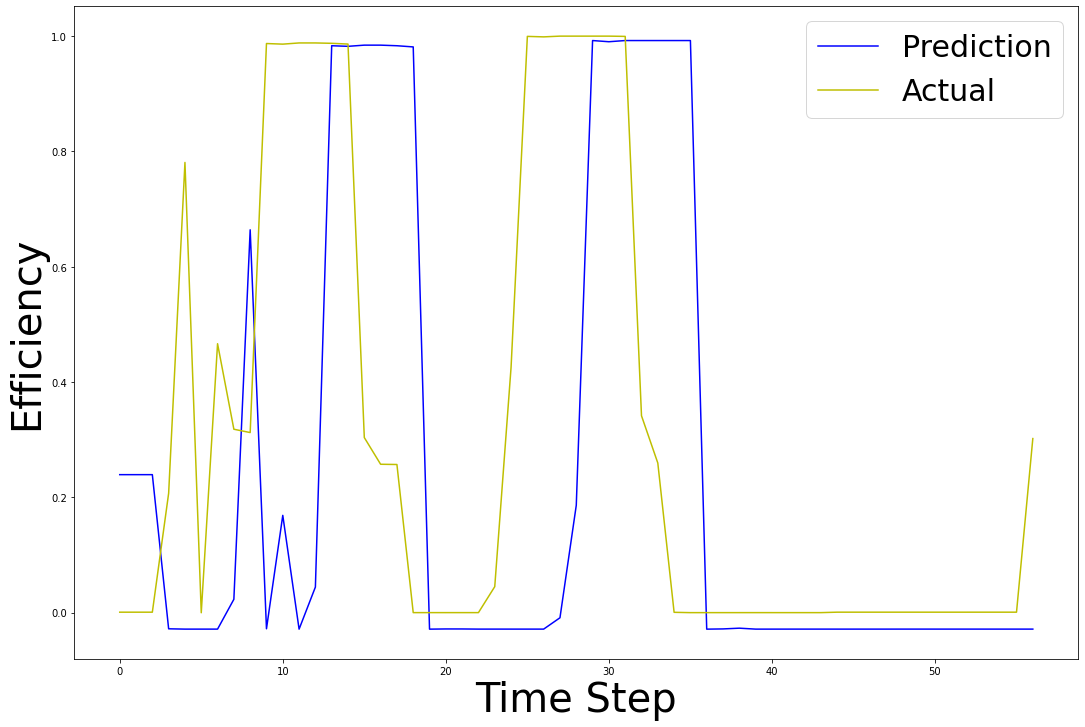

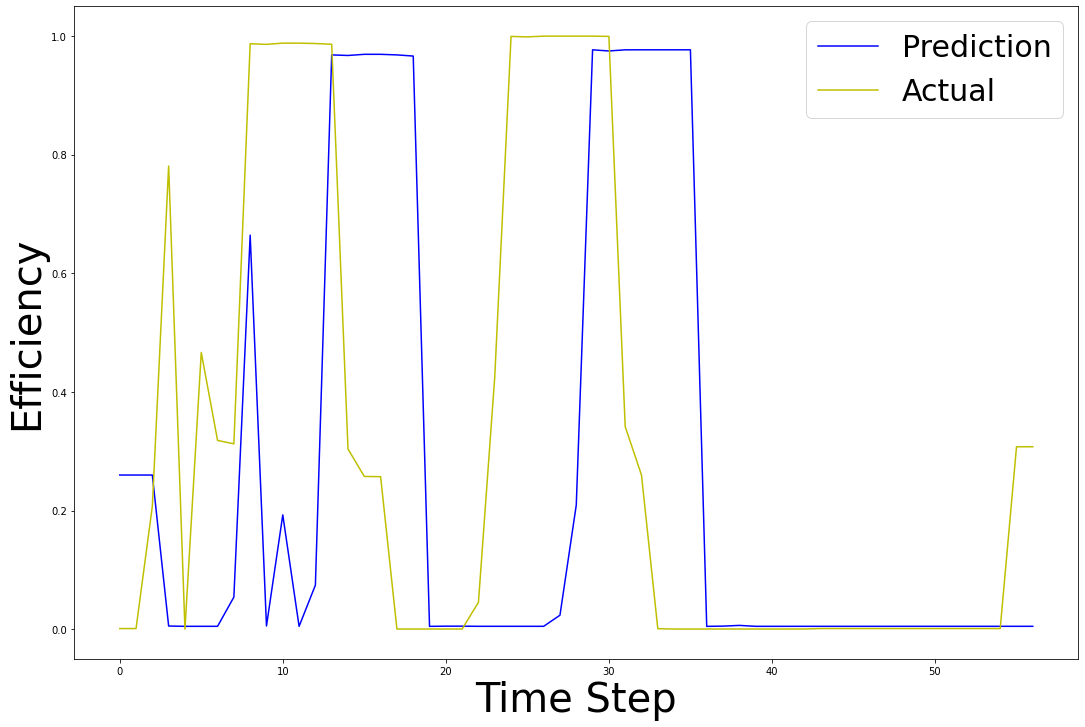

In [60]:
plot_res(res)#, save='tr_sw_t012_goyal')

# tr_sw_baseline model:
RMSE: 0.293494313955307
RMSPE: 0.9888595342636108
RMSSE: 0.9080561399459839

# ray_results
RMSE: 0.2802668809890747
RMSPE: 0.9442927837371826
RMSSE: 2.682858467102051

# tr_sw_t0_lb24
RMSE: 0.4566091001033783
RMSPE: 1.5384360551834106
RMSSE: 1.4127246141433716
